<a href="https://colab.research.google.com/github/thejarlid/makemore/blob/main/makemore_pt3/Makemore_pt3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!wget https://raw.githubusercontent.com/karpathy/makemore/refs/heads/master/names.txt

--2025-08-03 13:46:54--  https://raw.githubusercontent.com/karpathy/makemore/refs/heads/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.05s   

2025-08-03 13:46:54 (4.30 MB/s) - ‘names.txt’ saved [228145/228145]



In [3]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
# build the vocabulary of characters and mappints to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset

blocksize = 3 # context length: how many characters do we take to predict the next one
X, Y = [], []
for w in words:
  context = [0] * blocksize
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    context = context[1:] + [ix] # crop and append
X = torch.tensor(X)
Y = torch.tensor(Y)

In [6]:
X.shape, Y.shape # dataset

(torch.Size([228146, 3]), torch.Size([228146]))

In [ ]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

# training used for optimizing params
# validation used for development and tuning hyper parameters (size of embedding, strength of learning rate/regularization)
# test set is what we evaluate the actual model performance on at the end



In [7]:
# build the data set
block_size = 3

def build_dataset(words):
  blocksize = 3 # context length: how many characters do we take to predict the next one
  X, Y = [], []
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


# Activations, Gradients, & Batch Normalization

We have to be very careful when we initialize our network as it can lead to problems inactivation functions and percolating the gradient throughout the network.

## Random Initialization

In our example below as it came from pt2, our loss on the first iteration started at around 27 and then on the second iteration dropped to around 3.

Intuitively on initializtion we would assume that all output logits have equal probability but with random initialization this does not end up being the case since certain logits in the output may have vastly larger values than others leading to this high loss.

If our logits looked like the following [0.0, 0.0, 0.0, 0.0], then each index will have equal probability when we perform the softmax over this [0.25, 0.25, 0.25, 0.25]. Logits is defined as ```h @ W2 + b2``` and so we could set both W2 and b2 to be initialized as all 0s and this would achieve this, however its not a great idea. It is better to set W2 to be a very small value such as 0.01.

In [19]:
# MLP revisited
n_embed = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number ofneurons in the hidden layer of the mlp

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed),             generator=g)
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * (5/3)/((n_embed*block_size)**0.5)
# b1 = torch.randn(n_hidden,                         generator=g) * 0.01 # we comment this out since with batch normalization we actually subtract the mean from our hpreact so essentially the bias gets subtracted after being added
W2 = torch.randn((n_hidden, vocab_size),           generator=g) * 0.01
b2 = torch.randn(vocab_size,                       generator=g) * 0

# Batch Norm params <- generally added throughout the network
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.zeros((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]

print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

12097


In [20]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  # mini batch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors

  # Linear Layer
  hpreact = embcat @ W1 # + b1 # hidden layer pre-activation

  # batch normalization layer
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias # batch normalization
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

  # Non linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backwards pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
  lossi.append(loss.log10().item())

      0/ 200000: 3.3239


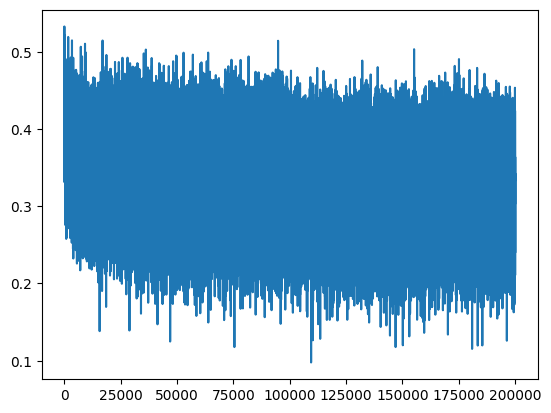

In [ ]:
plt.plot(lossi)

In [ ]:
@torch.no_grad # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
      'train': (Xtr, Ytr),
      'val': (Xdev, Ydev),
      'test': (Xte, Yte),
  }[split]

  emb = C[x] # (N, block_size, n_embed)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embed)
  hpreact = embcat @ W1 # + b1
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias # batch normalization
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0674147605895996
val 2.1056840419769287


In [ ]:
# sample form the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
  out = []
  context = [0] * block_size # initialize with all '...'
  while True:
    emb = C[torch.tensor([context])] # (1, block_size, n_embed)
    h = torch.tanh(emb.view(1, -1) @ W1 ) # + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)

    # sample from the distribution
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()

    # shift the context window and track the samples
    context = context[1:] + [ix]
    out.append(ix)

    # if we sample the special '.' token, break
    if ix == 0:
      break

  print(''.join([itos[i] for i in out]))

briahgmnazzierstel.
fhal.
qetvangendra.
zasderidgmlillshi.
jedrekesslangfarremyahmilkarib.
shdumrithghnestin.
jewtdvi.
xibuscfsubferndersymusemels.
kaylahshmyah.
haz.
sadya.
sufizajahkirrentirbbisvekostep.
qwilfeyroshbh.
zprixabumushwa.
hmarishid.
qinfelvshlwaldarikthrishthzighikassmitgftrvissivishten.
riefhrriyaxabushdumichekitya.
blvardtai.
bdgihzirrlq.
saadenaysophlrystta.


# PYTORCH SUMMARY -----

In [ ]:
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True

    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)

    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)


  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var

    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gama * xhat + self.beta

    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:

  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return []


n_embd = 10 # the dimensionality of the character embedding vector
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd))
layers = [
    Linear(n_embed * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(            n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(            n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(            n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(            n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(            n_hidden, vocab_size), BatchNorm1d(n_hidden),
]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].weight *= 0.1

  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

46497


In [ ]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  # mini batch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function

  # backwards pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph

  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
  lossi.append(loss.log10().item())

  break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2942


layer %d (%10s): mean %+.2f, std %+.2f, saturated %.2f%% (1, 'Tanh', tensor(-0.0243, grad_fn=<MeanBackward0>), tensor(0.7958, grad_fn=<StdBackward0>), tensor(29.6875))
layer %d (%10s): mean %+.2f, std %+.2f, saturated %.2f%% (3, 'Tanh', tensor(0.0694, grad_fn=<MeanBackward0>), tensor(0.6986, grad_fn=<StdBackward0>), tensor(12.4688))
layer %d (%10s): mean %+.2f, std %+.2f, saturated %.2f%% (5, 'Tanh', tensor(-0.0474, grad_fn=<MeanBackward0>), tensor(0.6819, grad_fn=<StdBackward0>), tensor(8.0312))
layer %d (%10s): mean %+.2f, std %+.2f, saturated %.2f%% (7, 'Tanh', tensor(0.0385, grad_fn=<MeanBackward0>), tensor(0.6636, grad_fn=<StdBackward0>), tensor(6.5625))
layer %d (%10s): mean %+.2f, std %+.2f, saturated %.2f%% (9, 'Tanh', tensor(-0.0428, grad_fn=<MeanBackward0>), tensor(0.6650, grad_fn=<StdBackward0>), tensor(6.4688))


Text(0.5, 1.0, 'activation distribution')

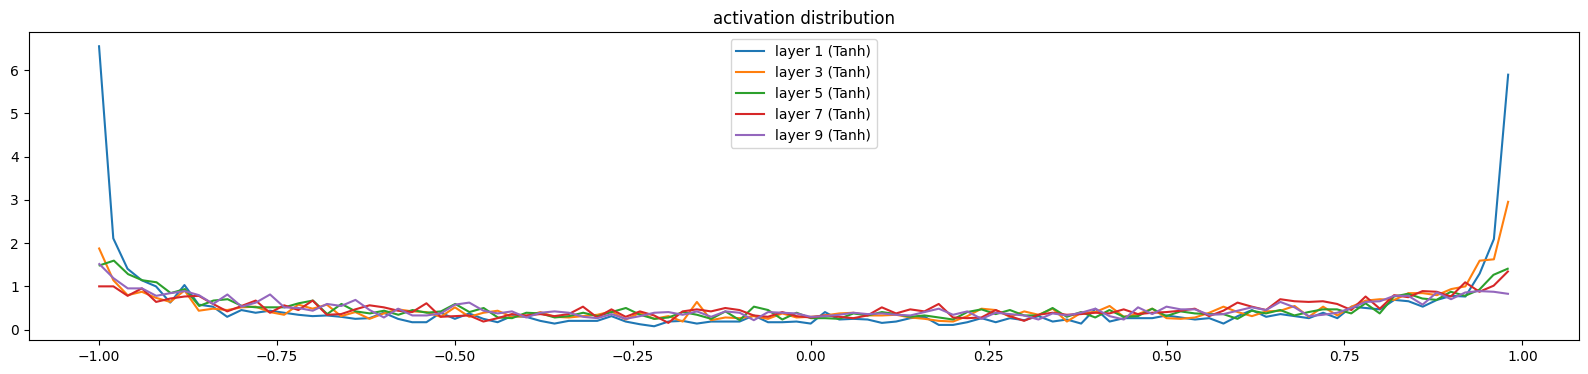

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %+.2f, saturated %.2f%%', (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('activation distribution')

layer %d (%10s): mean %+.2f, std %+.2f (1, 'Tanh', tensor(9.9389e-06), tensor(0.0004))
layer %d (%10s): mean %+.2f, std %+.2f (3, 'Tanh', tensor(-2.3180e-06), tensor(0.0004))
layer %d (%10s): mean %+.2f, std %+.2f (5, 'Tanh', tensor(2.1294e-06), tensor(0.0004))
layer %d (%10s): mean %+.2f, std %+.2f (7, 'Tanh', tensor(-7.8779e-07), tensor(0.0003))
layer %d (%10s): mean %+.2f, std %+.2f (9, 'Tanh', tensor(2.0751e-06), tensor(0.0003))


Text(0.5, 1.0, 'gradient distribution')

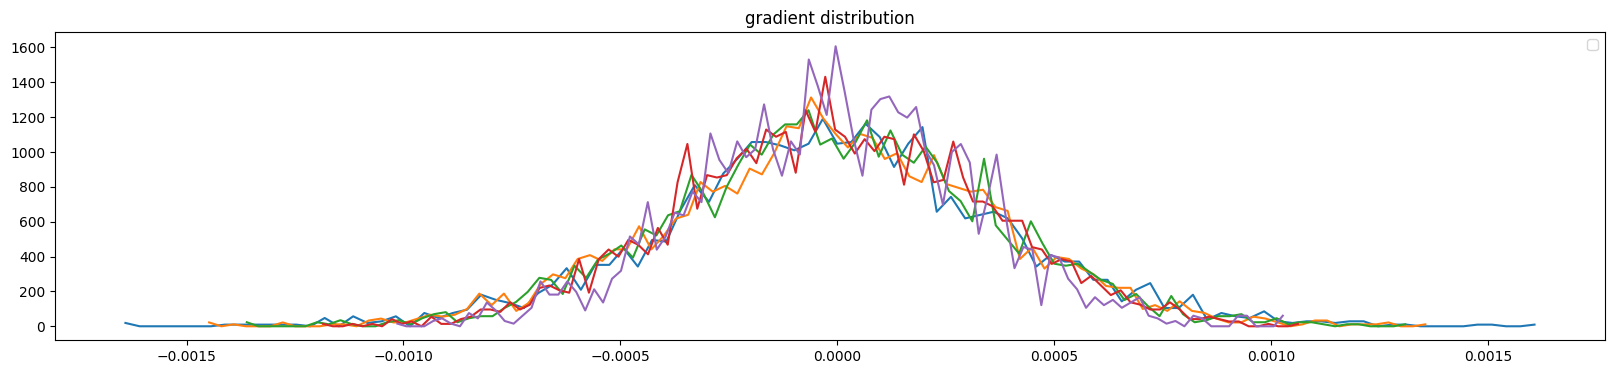

In [ ]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+.2f, std %+.2f', (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
plt.legend(legends)
plt.title('gradient distribution')

In [ ]:
@torch.no_grad # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
      'train': (Xtr, Ytr),
      'val': (Xdev, Ydev),
      'test': (Xte, Yte),
  }[split]

  emb = C[x] # (N, block_size, n_embed)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embed)
  hpreact = embcat @ W1 # + b1
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias # batch normalization
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

TODO: go back through the 3rd lecture and document more notes around the details of activation functions